# Exploratory Data Analysis

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Visualization

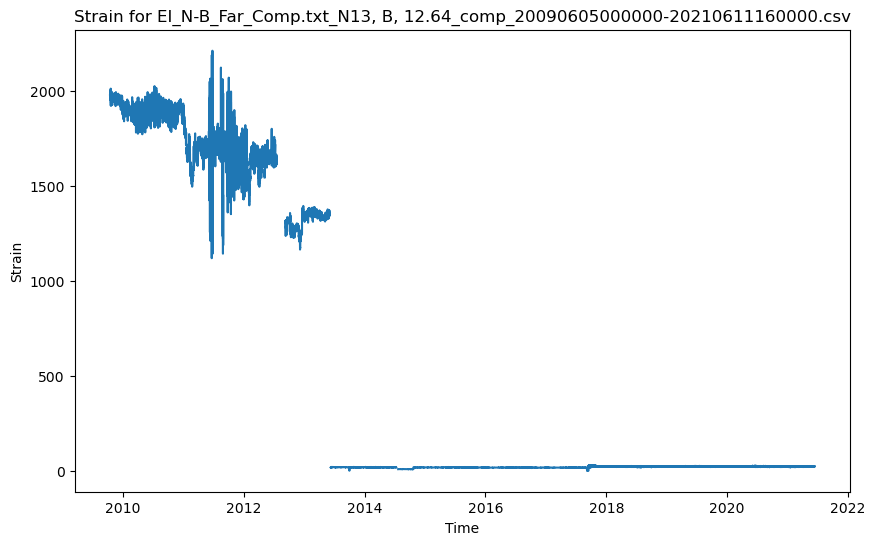

In [ ]:
#Visualize the raw data

folder = '../timeseries_csv/' #main folder
file = 'EI_N-B_Far_Comp.txt_N13, B, 12.64_comp_20090605000000-20210611160000.csv' #file name

df = pd.read_csv(folder + file, parse_dates=['Time'])

#Customized start and end time
#Choose start and end time (start '2009-06-05 00:00:00', end '2021-06-11 16:00:00')
# start_time = '2013-06-03 08:00:00'
# end_time = '2021-06-11 16:00:00'

# df = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]


plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.show()

          Time_index                Time  Strain
8579  20131001080000 2013-10-01 08:00:00     0.0
8580  20131001120000 2013-10-01 12:00:00     0.0


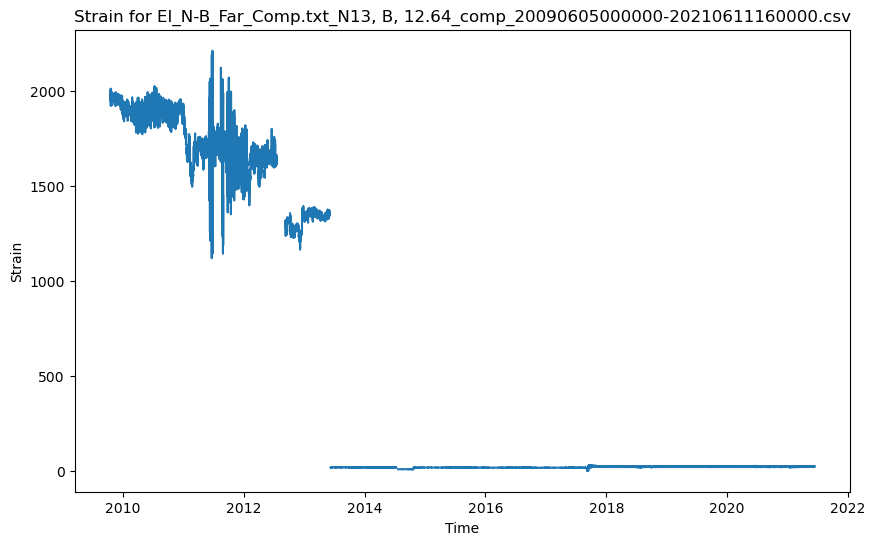

In [51]:
#Find values of strain that are exactly zero and remove them
df_zero = df[df["Strain"] == 0]
print(df_zero)

#Remove rows with strain values of zero and plot
indices_to_remove = df_zero.index
df = df.drop(index=indices_to_remove)
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.show()

### Statistics

In [52]:
#Print the statistics of the data
df['Strain'].describe()

count    24481.000000
mean       520.601363
std        772.099019
min          0.552510
25%         17.634130
50%         21.632490
75%       1359.334000
max       2211.697000
Name: Strain, dtype: float64

Text(0.5, 1.0, 'Box Plot of Strain')

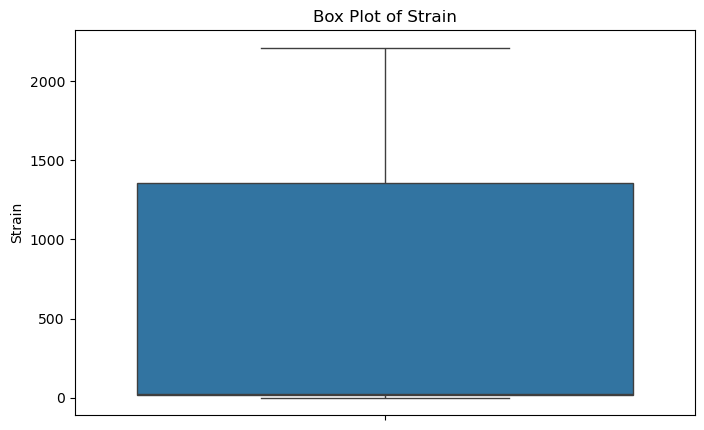

In [53]:
#Boxplot of strain values
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Strain'])

plt.ylabel('Strain')
plt.title(f'Box Plot of Strain')

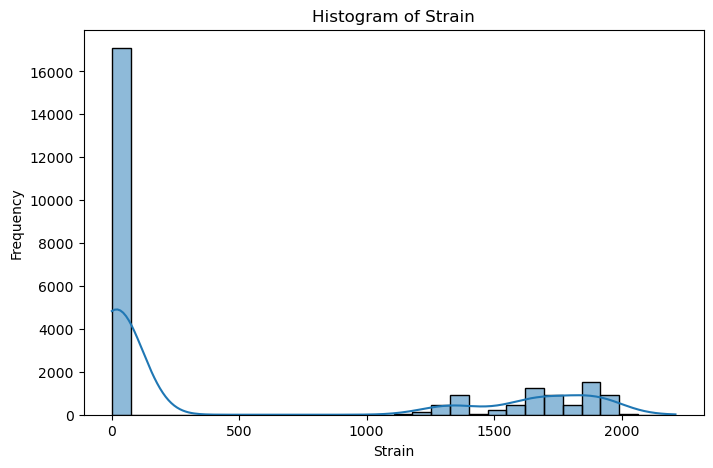

In [54]:
# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(df['Strain'], bins=30, kde=True)  # kde=True adds a density curve

# Labels and title
plt.xlabel('Strain')
plt.ylabel('Frequency')
plt.title('Histogram of Strain')

# Show plot
plt.show()

### Missing values

In [55]:
#Count the number of NaN values in each column
df.isna().sum()

# Get the indices of NaN values in the 'Strain' column
nan_indices = df[df['Strain'].isna()].index.tolist()

nan_indices_with_time = pd.DataFrame({
    # 'Index': nan_indices,
    'Time': df.loc[nan_indices, 'Time']
})

nan_indices_with_time

,Time
0,2009-06-05 00:00:00
1,2009-06-05 04:00:00
2,2009-06-05 08:00:00
3,2009-06-05 12:00:00
172,2009-11-13 08:00:00
...,...
24619,2021-02-11 00:00:00
24620,2021-02-11 04:00:00
24671,2021-02-19 16:00:00
24672,2021-02-22 12:00:00


Lenght: 312, Start Time: 2012-07-18 12:00:00, End Time: 2012-09-11 04:00:00
Lenght: 85, Start Time: 2012-09-21 08:00:00, End Time: 2012-10-05 08:00:00
Lenght: 67, Start Time: 2014-07-11 12:00:00, End Time: 2014-07-22 12:00:00
Lenght: 23, Start Time: 2011-11-25 16:00:00, End Time: 2011-11-29 08:00:00
Lenght: 21, Start Time: 2013-11-22 00:00:00, End Time: 2013-11-25 08:00:00


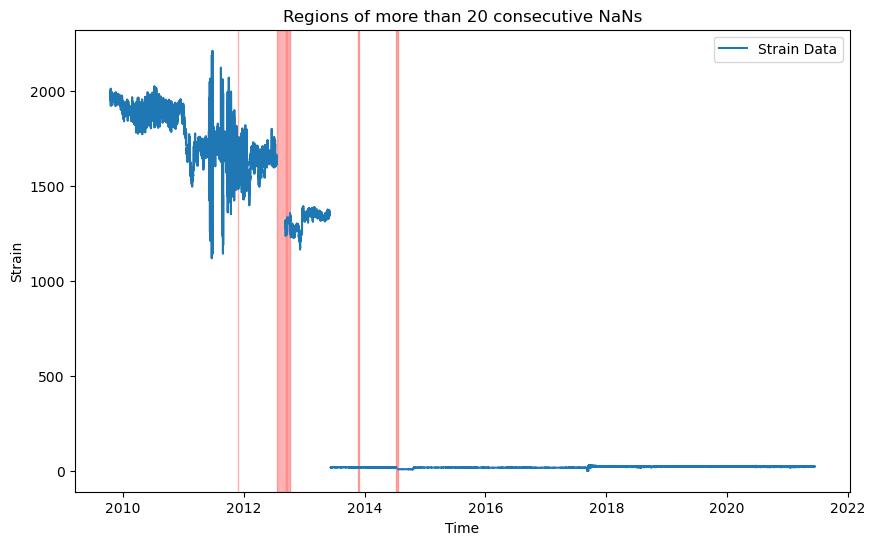

In [56]:
def find_nan_regions(threshold):
    """
    Find regions with more than 'threshold' consecutive NaNs in the 'Strain' column of the DataFrame.

    Args: 
        threshold (int): Minimum number of consecutive NaN values to consider as a region.

    Returns:
        consecutive_nan_regions (list): List of tuples containing the start and end indices of consecutive NaN regions.
        nan_regions_sorted (list): List of tuples containing the start and end indices, start and end times, and length of each NaN region, sorted by length in descending order.
    """
    consecutive_nan_regions = []
    start_idx = None

    for i in range(1, len(nan_indices)):
        if nan_indices[i] == nan_indices[i-1] + 1:  # Check for consecutive indices
            if start_idx is None:  # Start of consecutive NaNs
                start_idx = nan_indices[i-1]
        else:  # End of consecutive NaNs
            if start_idx is not None and i - nan_indices.index(start_idx) > threshold:  # More than 2 consecutive NaNs
                consecutive_nan_regions.append((start_idx, nan_indices[i-1]))
            start_idx = None

    # Handle the case where consecutive NaNs end at the last index
    if start_idx is not None and len(nan_indices) - nan_indices.index(start_idx) > threshold:
        consecutive_nan_regions.append((start_idx, nan_indices[-1]))

    nan_regions_sorted = []
    for start, end in consecutive_nan_regions:
        start_time = df.loc[start, 'Time']
        end_time = df.loc[end, 'Time']
        lenght = end - start + 1
        nan_regions_sorted.append((start, end, start_time, end_time, lenght))
        nan_regions_sorted = sorted(nan_regions_sorted, key=lambda x: x[4], reverse=True)

    return consecutive_nan_regions, nan_regions_sorted


thresholds = [20] # Choose the threshold(s) for consecutive NaNs
for threshold in thresholds:
    consecutive_nan_regions, nan_regions_sorted = find_nan_regions(threshold)
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time'], df['Strain'], linestyle='-', label="Strain Data")

    # Shade regions with more than 2 consecutive NaNs
    for start, end in consecutive_nan_regions:
        plt.axvspan(df['Time'].iloc[start], df['Time'].iloc[end], color='red', alpha=0.3)

    # Labels and title
    plt.xlabel('Time')
    plt.ylabel('Strain')
    plt.title(f'Regions of more than {threshold} consecutive NaNs')
    plt.legend()
    
    for column in nan_regions_sorted:
        print(f"Lenght: {column[4]}, Start Time: {column[2]}, End Time: {column[3]}")
    plt.show()


### Outliers

Lower bound = -1994.9156750000002 Extreme lower bound = -4007.4654800000003
Upper bound = 3371.8838050000004 Extreme upper bound = 5384.43361


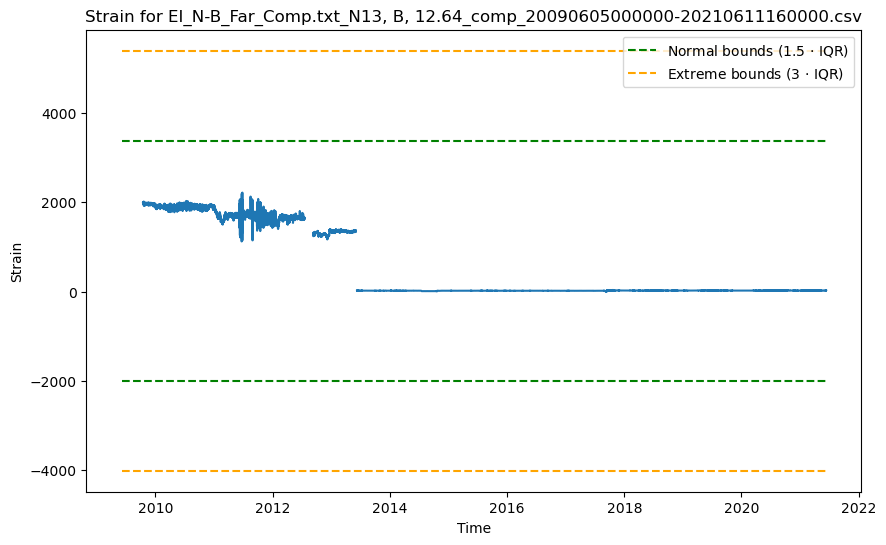

In [57]:
# Compute IQR
Q1 = df['Strain'].quantile(0.25)  # 25th percentile
Q3 = df['Strain'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1

# Define bounds for extreme outliers
lower_bound = Q1 - 1.5 * IQR
lower_bound_extreme = Q1 - 3 * IQR
upper_bound = Q3 + 1.5 * IQR
upper_bound_extreme = Q3 + 3 * IQR
print(f'Lower bound = {lower_bound} Extreme lower bound = {lower_bound_extreme}')
print(f'Upper bound = {upper_bound} Extreme upper bound = {upper_bound_extreme}')


plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.hlines(y=[lower_bound, upper_bound], xmin=df['Time'].iloc[0], xmax=df['Time'].iloc[-1], 
           colors='green', linestyles='dashed', label=r'Normal bounds (1.5 $\cdot$ IQR)')
plt.hlines(y=[lower_bound_extreme, upper_bound_extreme], xmin=df['Time'].iloc[0], xmax=df['Time'].iloc[-1], 
           colors='orange', linestyles='dashed', label=r'Extreme bounds (3 $\cdot$ IQR)')
plt.legend()
plt.show()

In [58]:
# Count mild outliers (outside 1.5 * IQR)
mild_outliers = df[(df['Strain'] < lower_bound) | (df['Strain'] > upper_bound)]
num_mild_outliers = mild_outliers.shape[0]

# Count extreme outliers (outside 3 * IQR)
extreme_outliers = df[(df['Strain'] < lower_bound_extreme) | (df['Strain'] > upper_bound_extreme)]
num_extreme_outliers = extreme_outliers.shape[0]

# Print results
print(f'Number of mild outliers (1.5 × IQR): {num_mild_outliers}')
print(f'Number of extreme outliers (3 × IQR): {num_extreme_outliers}')


Number of mild outliers (1.5 × IQR): 0
Number of extreme outliers (3 × IQR): 0


### Availability of data

Number of channels: 274


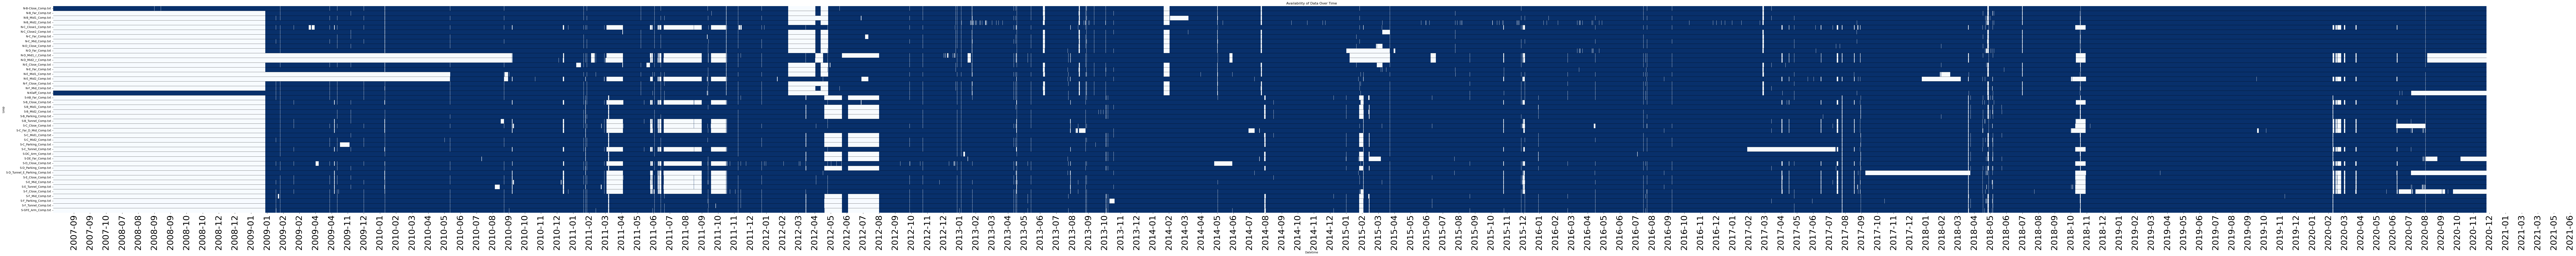

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def heatmap(loops_to_keep):
    # Read and process data
    df = pd.read_csv('txt/filelist.txt', delimiter=',', header=None)
    df.rename(columns={df.columns[0]: 'Date_path'}, inplace=True)
    df['Datetime'] = pd.to_datetime(df['Date_path'], format='%Y%m%d%H%M%S')
    df.rename(columns={df.columns[1]: 'Loop'}, inplace=True)
    dates = df['Datetime'].unique()

    loop_counts = df['Loop'].value_counts()
    print(f'Number of channels: {len(loop_counts)}')

    if loops_to_keep == 'all':
        # Keep all rows if 'all' is selected
        pass
    elif isinstance(loops_to_keep, str) and loops_to_keep.endswith('.txt'):
        # If it's a file path, read the loop names from the file
        with open(loops_to_keep, 'r') as f:
            loops_to_keep = [line.strip() for line in f.readlines()]  # Read and clean loop names
        # Filter the DataFrame to only keep the rows with the loops in the 'loops_to_keep' list
        df = df[df['Loop'].isin(loops_to_keep)]
    else:
        # If it's a list of loop names, use that list
        df = df[df['Loop'].isin(loops_to_keep)]

    # Create a boolean matrix using pivot_table()
    boolean_matrix = df.pivot_table(index='Loop', columns='Datetime', aggfunc=lambda x: 1, fill_value=0)
    boolean_matrix.columns = boolean_matrix.columns.droplevel(0)  # Drop the 'Date_path' level

    # Plot heatmap with horizontal lines only
    plt.figure(figsize=(160, 0.3*len(loops_to_keep)))
    ax = sns.heatmap(boolean_matrix, cmap="Blues", cbar=False)

    plt.title("Availability of Data Over Time")

    # Ensure labels are not rotated
    step = int(len(dates) / (len(dates)/30.5/6))
    ax.set_xticks(range(235, len(dates), step))  # Set ticks at intervals (235 is when September begins so that the ticks are at the beginning of each month)
    ax.set_xticklabels([dates[i].strftime('%Y-%m') for i in range(235, len(dates), step)], rotation=90, fontsize=30)

    ax.hlines(y=[i + 1 for i in range(len(boolean_matrix))], xmin=0, xmax=len(boolean_matrix.columns), color='black', linewidth=0.5)

    ax.set_yticklabels(boolean_matrix.index, rotation=0)

    # Show plot
    plt.show()


# Define the option to read loops from a text file or specify 'all'
loops_to_keep = 'txt/comp_loops_notEI_filtered.txt'  # Option: 'all' or path to a text file (e.g., 'loops.txt')
title = 'Heatmap'
heatmap(loops_to_keep)

In [60]:
# import numpy as np

# # Identify NaN regions
# df['is_nan'] = df['Strain'].isna()  # Create a boolean column for NaNs

# plt.figure(figsize=(10, 6))
# plt.plot(df['Time'], df['Strain'], linestyle='-', label="Strain Data")

# # Shade regions with NaNs
# start_time = None
# for i in range(len(df)):
#     if df['is_nan'].iloc[i] and start_time is None:  # Start of NaN region
#         start_time = df['Time'].iloc[i]
#     elif not df['is_nan'].iloc[i] and start_time is not None:  # End of NaN region
#         end_time = df['Time'].iloc[i]
#         plt.axvspan(start_time, end_time, color='red', alpha=0.3)  # Shade NaN region
#         start_time = None

# # Handle if NaNs end at the last row
# if start_time is not None:
#     plt.axvspan(start_time, df['Time'].iloc[-1], color='red', alpha=0.3)

# # Labels and title
# plt.xlabel('Time')
# plt.ylabel('Strain')
# plt.title('NaN Regions in Strain Data')
# plt.legend()

# # Show the plot
# plt.show()